# 实验6 机器翻译 Seq2Seq + Attention

Author: 高鹏昺

Email: nbgao@126.com

Reference:  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py  
http://www.manythings.org/anki/

## Import

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('fra', 'eng', True)
print(random.choice(pairs))

Reading lines...
Read 170190 sentence pairs
Trimmed to 12702 sentence pairs
Counting words...
Counted words:
eng 4736
fra 3050
['vous n etes pas si interessantes .', 'you re not that interesting .']


## Model

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [29]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [30]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [32]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_epochs)]
    crepochion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, crepochion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Time: %s  Epoch: %d (%d%%)  Loss: %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    return plot_losses

In [47]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots(figsize=(16,6))
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.grid()

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Time: 1m 8s (- 16m 1s)  Epoch: 5000 (6%)  Loss: 2.9327
Time: 2m 12s (- 14m 20s)  Epoch: 10000 (13%)  Loss: 2.3292
Time: 3m 20s (- 13m 23s)  Epoch: 15000 (20%)  Loss: 2.0101
Time: 4m 29s (- 12m 21s)  Epoch: 20000 (26%)  Loss: 1.7909
Time: 5m 36s (- 11m 13s)  Epoch: 25000 (33%)  Loss: 1.5715
Time: 6m 45s (- 10m 8s)  Epoch: 30000 (40%)  Loss: 1.4377
Time: 7m 54s (- 9m 1s)  Epoch: 35000 (46%)  Loss: 1.2820
Time: 8m 58s (- 7m 51s)  Epoch: 40000 (53%)  Loss: 1.1937
Time: 10m 3s (- 6m 42s)  Epoch: 45000 (60%)  Loss: 1.0861
Time: 11m 8s (- 5m 34s)  Epoch: 50000 (66%)  Loss: 1.0247
Time: 12m 13s (- 4m 26s)  Epoch: 55000 (73%)  Loss: 0.9328
Time: 13m 20s (- 3m 20s)  Epoch: 60000 (80%)  Loss: 0.8718
Time: 14m 32s (- 2m 14s)  Epoch: 65000 (86%)  Loss: 0.8073
Time: 15m 43s (- 1m 7s)  Epoch: 70000 (93%)  Loss: 0.7515
Time: 16m 54s (- 0m 0s)  Epoch: 75000 (100%)  Loss: 0.6881


<Figure size 432x288 with 0 Axes>

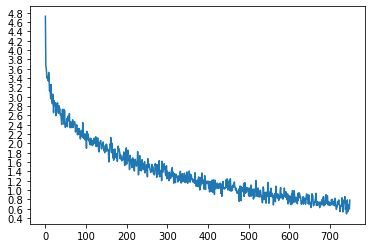

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainEpochs(encoder1, attn_decoder1, 75000, print_every=5000)
showPlot(plot_losses)

<Figure size 432x288 with 0 Axes>

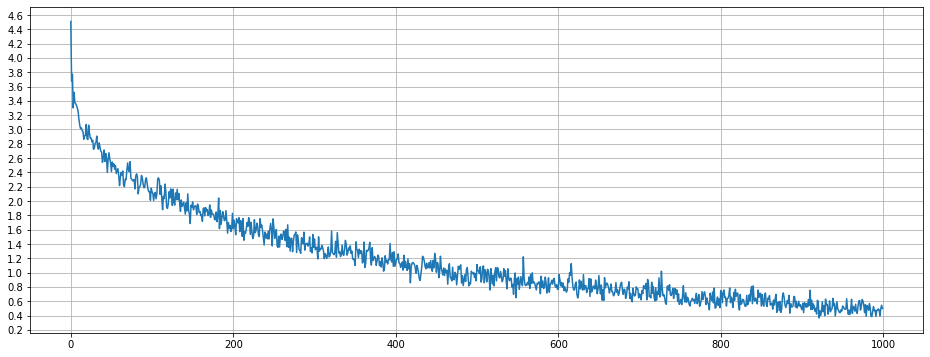

In [52]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainEpochs(encoder2, attn_decoder2, 100000, print_every=1000)
showPlot(plot_losses)

In [54]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes vraiment tres productive aujourd hui .
= you are really very productive today .
< you are really very productive today . <EOS>

> je suis la plus jeune enfant .
= i m the youngest in the family .
< i m the youngest child . <EOS>

> nous sommes toujours amis .
= we re still friends .
< we re still friends . <EOS>

> tu es merveilleux .
= you re wonderful .
< you re wonderful . <EOS>

> je vais lire quelques livres .
= i m going to read some books .
< i m going to read some books . <EOS>

> vous etes jeune et fort .
= you re young and strong .
< you re young and strong . <EOS>

> nous sommes tres occupes .
= we re very busy .
< we re very busy . <EOS>

> il est habitue a de telles situations .
= he is used to such situations .
< he is accustomed to such by . <EOS>

> tu es un tres bon artiste .
= you re a very good artist .
< you re a very good artist . <EOS>

> c est mon oncle .
= he is my uncle .
< he is my uncle . <EOS>



In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> tu n es pas contrariee si ?
= you re not upset are you ?
< you re not a city girl are you ? <EOS>

> tu es fantasque .
= you re temperamental .
< you re sleepy . <EOS>

> je suis convaincu que tu as raison .
= i m convinced that you re right .
< i m sure you re right . <EOS>

> vous etes tires d affaire .
= you re off the hook .
< you re off the hook . <EOS>

> je suis en train de payer .
= i m paying .
< i m eating . <EOS>

> vous etes charmantes .
= you re charming .
< you re overworked . <EOS>

> tu es la doyenne .
= you re the oldest .
< you re the oldest . <EOS>

> je bois une biere en ce moment meme .
= i m drinking a beer right now .
< i m having a beer right now . <EOS>

> je suis pratiquement un adulte maintenant .
= i m practically an adult now .
< i m making a now now . <EOS>

> nous sommes impuissants .
= we re powerless .
< we re powerless . <EOS>



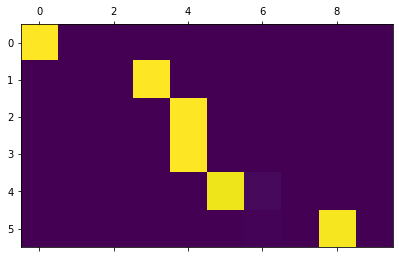

In [55]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>
input = elle est trop petit .
output = she s too short . <EOS>
input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he is a talented young . . . <EOS>


/home/nbgao/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


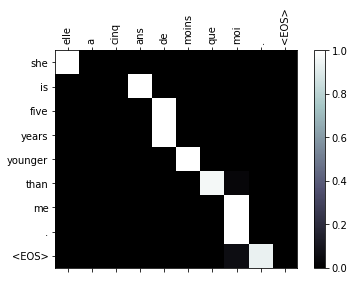

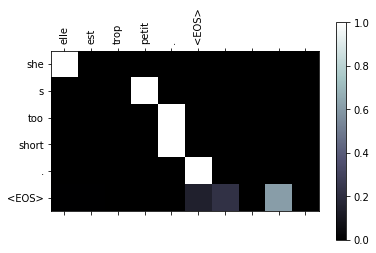

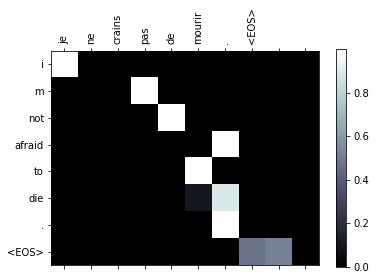

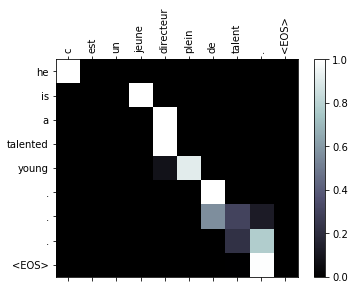

In [56]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")